In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
import os, random, matplotlib, pickle
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

SMALL_SIZE, MEDIUM_SIZE = 9, 12

<h1><font color="blue">Import Data</font></h1>

In [3]:
# *** DEFINE ***
fps=50
results_path = "results/test"

# Collect Data
pickle_in = open(f"{results_path}/files_ref.pickle","rb")
files_ref = pickle.load(pickle_in)
bodypoints = np.load(f"{results_path}/bodypoints.npy")
scales = np.load(f"{results_path}/scales.npy")
angles = np.load(f"{results_path}/angles.npy")
freq = np.load(f"{results_path}/freq.npy")
power = np.load(f"{results_path}/power.npy")
embed = np.load(f"{results_path}/embeddings.npy")

<h1><font color="blue">Visualize Data</font></h1>

In [11]:
# %matplotlib qt
%matplotlib inline

matplotlib.rc('font', size=MEDIUM_SIZE)
matplotlib.rc('axes', titlesize=MEDIUM_SIZE)

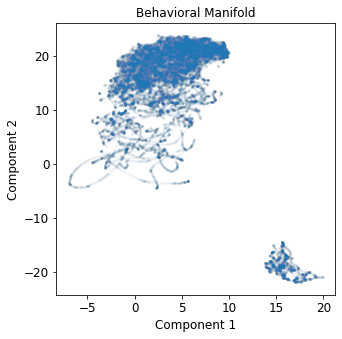

In [15]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(embed[:,0], embed[:,1], alpha=0.01, s=3)  
ax.set(xlabel='Component 1', ylabel='Component 2', title="Behavioral Manifold")
plt.show()

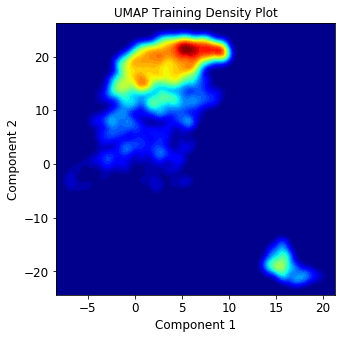

In [16]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.kdeplot(embed[:,0], embed[:,1], 
            shade=True, shade_lowest=True, gridsize=100, 
            levels=40, cmap='jet',cbar=False, ax=ax)
ax.set(xlabel='Component 1', ylabel='Component 2', title="UMAP Training Density Plot")
plt.show()

<h1><font color="blue">Cluster (GMM)</font></h1>

In [4]:
from sklearn.mixture import GaussianMixture

matplotlib.rc('font', size=MEDIUM_SIZE)
matplotlib.rc('axes', titlesize=MEDIUM_SIZE)

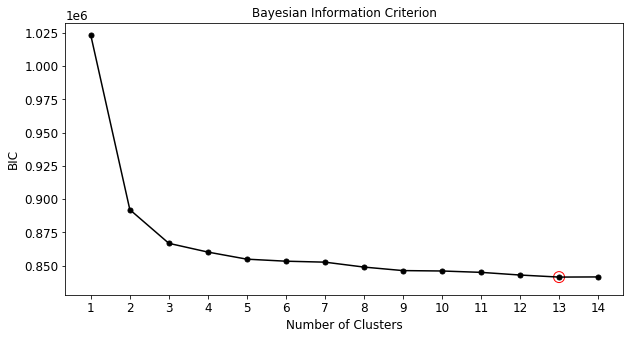

In [28]:
# *** DEFINE ***
max_cluster = 15

# Compute BIC
cluster_list = range(1, max_cluster)
bic_list = []
for n_components in tqdm(cluster_list):
    gmm = GaussianMixture(n_components)
    gmm.fit(embed)
    bic_list.append(gmm.bic(embed))
min_idx = np.argmin(bic_list)

# Plot
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(cluster_list, bic_list, marker="o", c='k', markersize=5)
ax.scatter(min_idx+1, bic_list[min_idx], s=120, edgecolors='r', facecolors='none')
ax.set_xticks(range(1, max_cluster))
ax.ticklabel_format(style="sci", scilimits=(0,5))
ax.set(xlabel='Number of Clusters', ylabel='BIC', title="Bayesian Information Criterion")
plt.show()

In [5]:
# Gaussian Mixture Model
gmm = GaussianMixture(n_components=10, max_iter=10000)
gmm_label = gmm.fit_predict(embed)

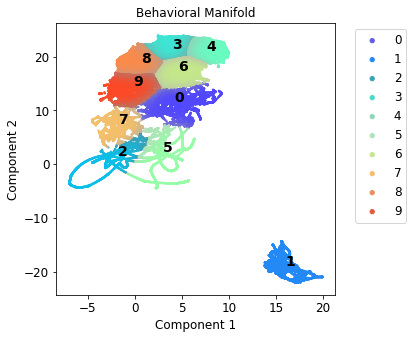

In [15]:
num_clusters = np.max(gmm_label) + 1
# compute probability
prob = np.max(gmm.predict_proba(embed), axis=1)

# choose color palette
color_palette = sns.color_palette('rainbow', num_clusters)
cluster_colors = [color_palette[x] for x in gmm_label]
cluster_member_colors = np.array([sns.desaturate(x, p) for x, p in zip(cluster_colors, prob)])

# create figures
fig, ax = plt.subplots(figsize=(5, 5))
for i in range(num_clusters):
    idx = (gmm_label==i)
    ax.scatter(embed[idx,0], embed[idx,1], 
                c=cluster_member_colors[idx], 
                alpha=1, s=2, label=i)
    ax.annotate(i, gmm.means_[i], fontsize=14, fontweight='bold')
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=3)
ax.set(xlabel="Component 1", ylabel="Component 2", title="Behavioral Manifold")
plt.show()

<h1><font color="blue">Power Spectrogram</font></h1>

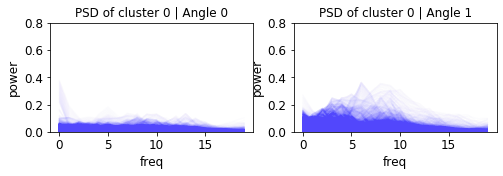

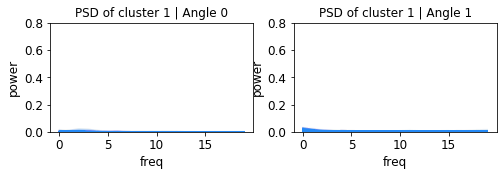

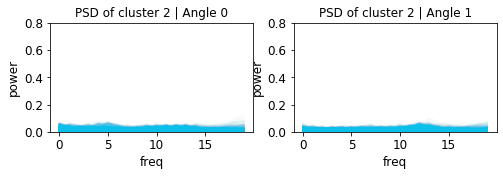

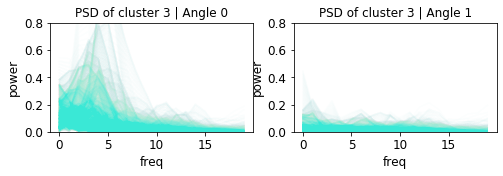

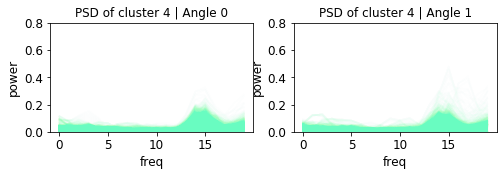

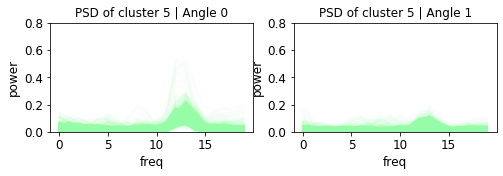

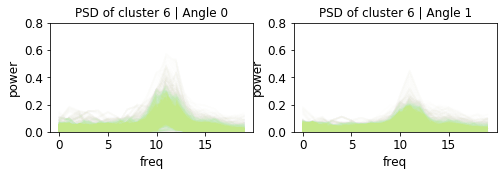

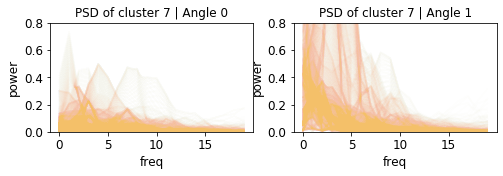

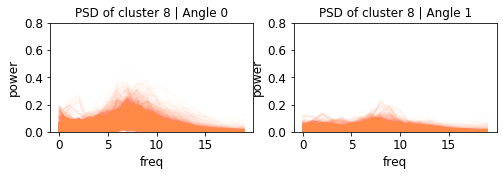

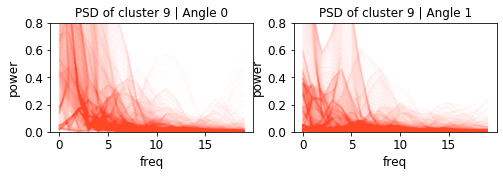

In [85]:
matplotlib.rc('font', size=MEDIUM_SIZE)
matplotlib.rc('axes', titlesize=MEDIUM_SIZE)

num_angles, num_freq, num_fr = power.shape

for i_cluster in range(num_clusters):
    idx_cluster = (gmm_label == i_cluster) & (prob>0.85)
    # plot
    fig, ax = plt.subplots(1,2,figsize=(8,2))
    for i_angle in range(num_angles):
        ax[i_angle].plot(power[i_angle,:,idx_cluster].T, alpha=0.01, c=color_palette[i_cluster])
        ax[i_angle].set_xlabel("freq"); ax[i_angle].set_ylabel("power"); ax[i_angle].set_title(f"PSD of cluster {i_cluster} | Angle {i_angle}")
        ax[i_angle].set_ylim([0,0.8])
    plt.show()

<h1><font color="blue">Video</font></h1>

In [7]:
from video import Video

matplotlib.rc('font', size=MEDIUM_SIZE)
matplotlib.rc('axes', titlesize=MEDIUM_SIZE)

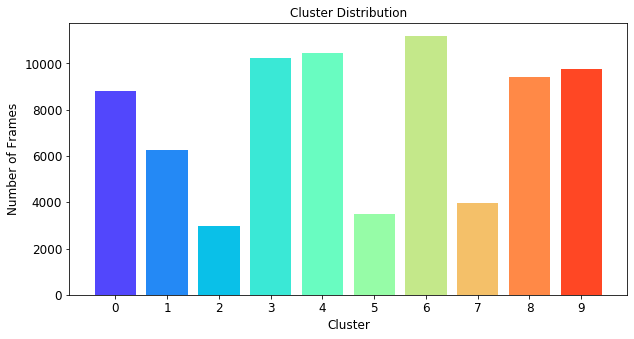

In [8]:
num_clusters = np.max(gmm_label) + 1
cluster_distribution = []
for clust_i in range(num_clusters):
    clust_idx = np.where(gmm_label==clust_i)[0]
    cluster_distribution.append(len(clust_idx))

# Distribution figure  
fig, ax = plt.subplots(figsize=(10,5)) 
xticks = [str(i) for i in range(num_clusters)]
ax.bar(xticks, cluster_distribution, color=color_palette)
ax.set(xlabel="Cluster", ylabel="Number of Frames", title="Cluster Distribution")
plt.show()

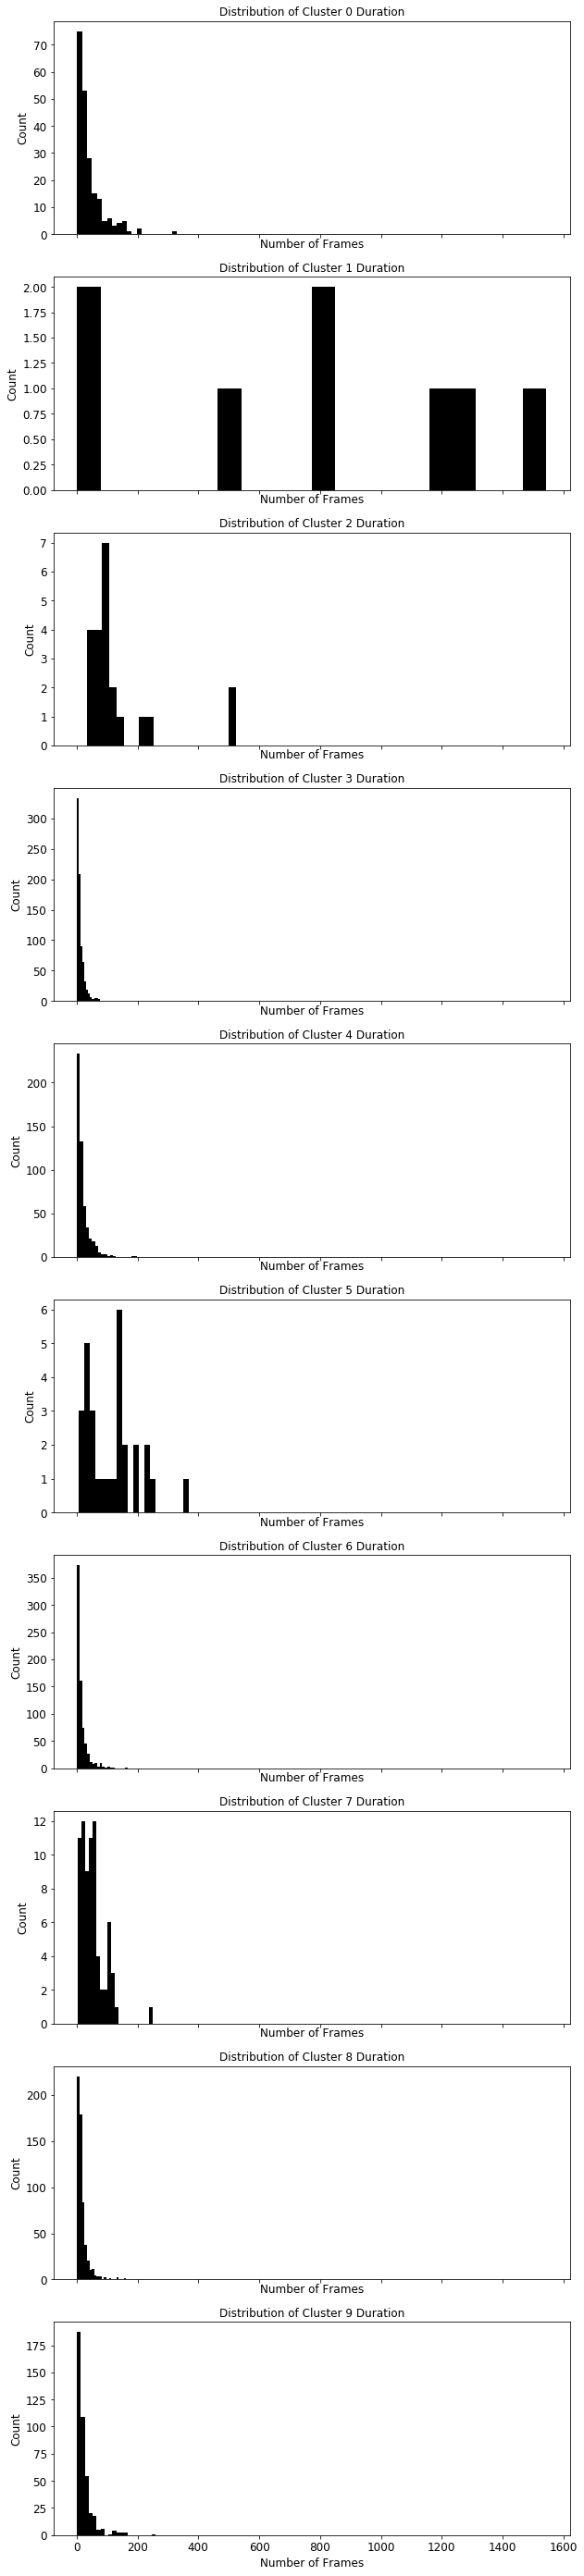

In [9]:
# *** DEFINE ***
num_videos = 5

fig, ax = plt.subplots(num_clusters, 1, figsize=(10,5*num_clusters), sharex=True)
video_cluster_idx = {}
for clust_i in range(num_clusters):
    clust_idx = np.where(gmm_label==clust_i)[0]
    difference = np.diff(clust_idx)
    
    # Find consecutive break
    break_idx = np.where(difference != 1)[0]
    mod_break_idx = np.insert(break_idx, 0, 0)
    break_difference = np.diff(mod_break_idx)
    
    # Find max consecutive
    sorted_idx = np.argsort(break_difference)
    top_idx = sorted_idx[-num_videos:]
    video_idx = [[ clust_idx[mod_break_idx[idx]+1], clust_idx[mod_break_idx[idx+1]+1]] for idx in top_idx]
    video_cluster_idx[clust_i] = video_idx
    
    # Cluster Duration Distribution
    ax[clust_i].hist(break_difference, bins=20, color='k')
    ax[clust_i].set(xlabel="Number of Frames", ylabel="Count", title=f"Distribution of Cluster {clust_i} Duration")
plt.show()

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1200x800', '-pix_fmt', 'rgba', '-r', '2', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', './videos/test3/cluster0_frame38879-39134.mp4']' returned non-zero exit status 255.

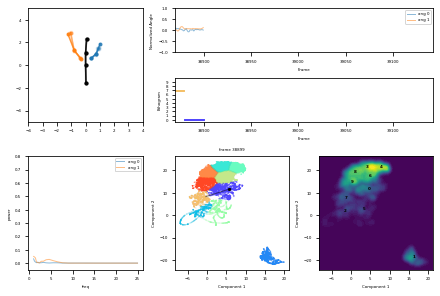

In [10]:
video_creator = Video(bodypoints=bodypoints, angles=angles, freq=freq, power=power,
                      embed=embed, cluster=gmm_label, cluster_mean=gmm.means_)
for clust_i, list_idx in tqdm(video_cluster_idx.items(), desc="Cluster Loop"):
    for (start_fr, stopfr) in tqdm(list_idx, desc="Ind Cluster Loop"):
        filepath = f"./videos/test3/cluster{clust_i}_frame{start_fr}-{stopfr}.mp4"
        video_creator.create_video(start_fr, stopfr, filepath, start_pad=10, stop_pad=10)

<h1><font color="blue">Caste and Environmental Conditions</font></h1>

In [21]:
%matplotlib inline
# %matplotlib qt

matplotlib.rc('font', size=MEDIUM_SIZE)
matplotlib.rc('axes', titlesize=MEDIUM_SIZE)

In [12]:
caste_data = {"min": [], "mid": [], "maj":[]}
env_data = {"trail": [], "food": [], "free":[], "groom":[]}
for key, fr_range in files_ref.items():
    # Caste Condition
    if key.find("min_") is not -1:
        caste_data["min"].extend(range(fr_range[0], fr_range[1]))
    if key.find("mid_") is not -1:
        caste_data["mid"].extend(range(fr_range[0], fr_range[1]))
    if key.find("maj_") is not -1:
        caste_data["maj"].extend(range(fr_range[0], fr_range[1]))
    
    # Environmental Conditions
    if key.find("trail") is not -1:
        env_data["trail"].extend(range(fr_range[0], fr_range[1]))
    if key.find("food") is not -1:
        env_data["food"].extend(range(fr_range[0], fr_range[1]))
    if key.find("free") is not -1:
        env_data["free"].extend(range(fr_range[0], fr_range[1]))
    if key.find("groom") is not -1:
        env_data["groom"].extend(range(fr_range[0], fr_range[1]))

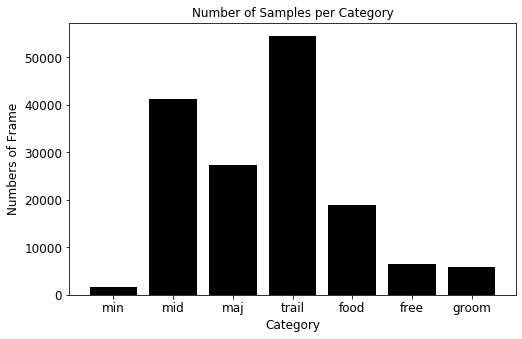

In [22]:
data_type = []
type_num_fr = []

fig, ax = plt.subplots(figsize=(8, 5))
for key, val in caste_data.items():
    data_type.append(key)
    type_num_fr.append(len(val))
for key, val in env_data.items():
    data_type.append(key)
    type_num_fr.append(len(val))
    
ax.bar(data_type, type_num_fr, color='k')
ax.set(xlabel='Category', ylabel='Numbers of Frame', title="Number of Samples per Category")
plt.show()

min
mid
maj


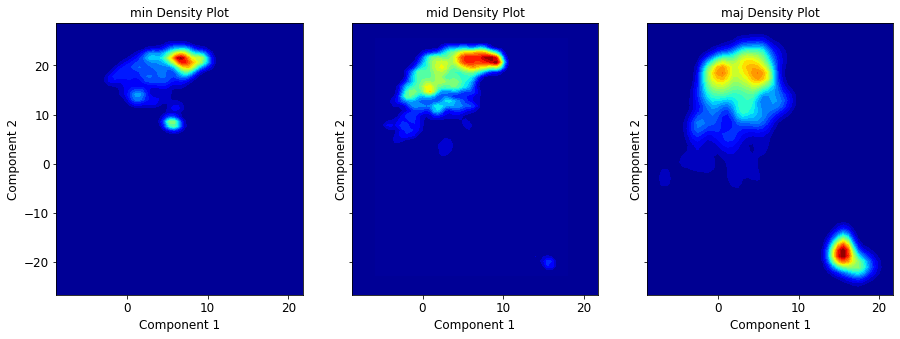

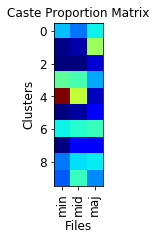

In [17]:
# caste
caste_proportion_matrix = np.zeros((3, num_clusters))
caste_row_name=[]

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
for idx, (key, fr_idx) in enumerate(caste_data.items()):
    print(key)
    # density
    sns.kdeplot(embed[fr_idx,0], embed[fr_idx,1], ax=ax[idx], shade=True,
                      gridsize=50, levels=25, cmap='jet',cbar=False)
    ax[idx].set(xlabel='Component 1', ylabel='Component 2', 
                title=f"{key} Density Plot", facecolor='#000096')
    # proportion
    caste_row_name.append(key)
    cluster = gmm_label[fr_idx]
    for clust_i in range(num_clusters):
        caste_proportion_matrix[idx, clust_i] = len(np.where(cluster == clust_i)[0])/len(cluster)
plt.show()

fig, ax = plt.subplots(figsize=(8,3))       
ax.imshow(caste_proportion_matrix.T, cmap="jet")
plt.xticks(np.arange(3), caste_row_name, rotation=90)
ax.set(ylabel='Clusters', xlabel='Files', 
                title=f"Caste Proportion Matrix")
plt.show()

trail
food
free
groom


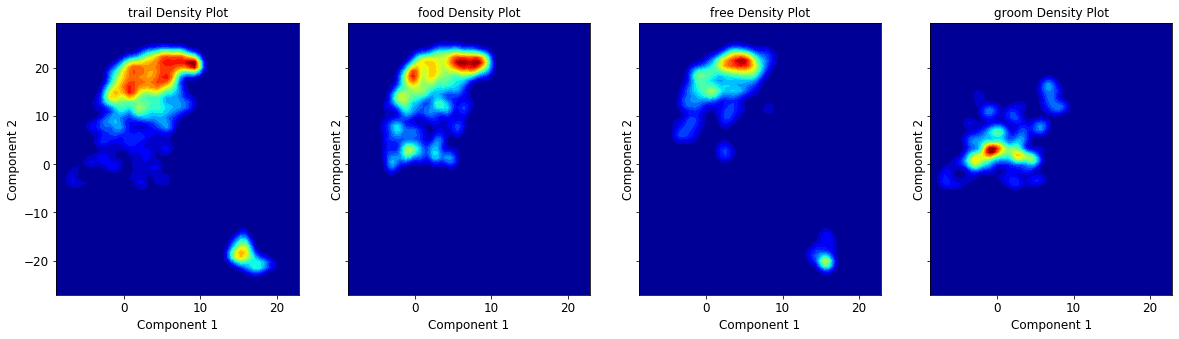

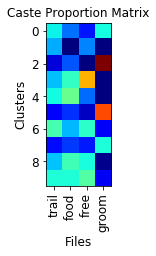

In [18]:
# Environment
env_proportion_matrix = np.zeros((4, num_clusters))
env_row_name=[]

fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)
for idx, (key, fr_idx) in enumerate(env_data.items()):
    print(key)
    # density
    sns.kdeplot(embed[fr_idx,0], embed[fr_idx,1], ax=ax[idx] , shade=True,
                      gridsize=50, levels=25, cmap='jet',cbar=False)
    ax[idx].set(xlabel='Component 1', ylabel='Component 2', 
                title=f"{key} Density Plot", facecolor='#000096')
    # proportion
    env_row_name.append(key)
    cluster = gmm_label[fr_idx]
    for clust_i in range(num_clusters):
        env_proportion_matrix[idx, clust_i] = len(np.where(cluster == clust_i)[0])/len(cluster)
plt.show()

fig, ax = plt.subplots(figsize=(8,3))       
ax.imshow(env_proportion_matrix.T, cmap="jet")
plt.xticks(np.arange(4), env_row_name, rotation=90)
ax.set(ylabel='Clusters', xlabel='Files', 
                title=f"Caste Proportion Matrix")
plt.show()

<h1><font color="blue">Proportion Matrix</font></h1>

In [49]:
%matplotlib qt
import textwrap

matplotlib.rc('font', size=6)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

In [50]:
num_cluster = np.max(gmm_label)+1
num_files = len(files_ref)

proportion_matrix = np.zeros((len(files_ref), num_cluster))
row_name = []

for files_idx, (path, fr_range) in enumerate(files_ref.items()):
    # Parse Files
    base = os.path.basename(path)
    basename = base.split("DeepCut")[0]
    row_name.append(basename)
    cluster = gmm_label[fr_range[0]:fr_range[1]]
    # Create Proportion Matrix
    for clust_i in range(num_cluster):
        proportion_matrix[files_idx, clust_i] = len(np.where(cluster == clust_i)[0])/len(cluster)

# Proportion Figure
fig, ax = plt.subplots(figsize=(20,5)) 
ax.imshow(proportion_matrix.T, cmap="jet")

row_name_mod = [row.replace("_", "\n").replace("-", "\n").replace("2018", "18") for row in row_name]

plt.xticks(np.arange(num_files), row_name_mod, rotation=0)
ax.set(ylabel='Clusters', xlabel='Files', 
                title=f"Proportion Matrix")
plt.tight_layout(pad=0)
plt.show()